In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od
import seaborn as sns
import math
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from datetime import datetime

# Competition
https://www.kaggle.com/competitions/big-data-derby-2022/overview

# References
https://www.kaggle.com/code/chemdata/intro-to-time-series-analysis-forecasting

https://www.kaggle.com/code/lichtlab/hierarchical-bayesian-estimation-horse-power

For the basics of some DS techniques

https://www.kaggle.com/code/bhatnagardaksh/big-data-derby-clustering-pca-classification

Visualization

https://www.kaggle.com/code/venkatkumar001/big-data-derby-explore-eda-approach-try-it

Basic EDA

https://www.kaggle.com/code/ozoozo/big-data-derby-2022-starter-eda

Convert lat long to x y position data

https://www.kaggle.com/code/andrewebenbach/making-latitude-and-longitude-usable-for-distances

FANTASTIC INITIAL ANALYSIS FOR SPEED

https://www.kaggle.com/code/monogenea/big-data-derby-2022-a-performance-proxy

# To Do

One hot encode categorical data as a preprocessing step

Split dates?

Bar Charts for Distance, track type, run up distance, etc, for each track

Odds by jockey

Convert lat long to x y in meters

Plot velocity and acceleration by distance for each track

Create math for drafting


# Import Data

In [2]:
if 'inputs' not in os.listdir('.'):
    od.download('https://www.kaggle.com/competitions/big-data-derby-2022')
    os.rename('big-data-derby-2022/','inputs/')

In [3]:
start = pd.read_csv('inputs/nyra_start_table.csv', header=None)
start.columns = ['track_id','race_date','race_number','program_number','weight_carried','jockey','odds','finishing_position']
start.head()

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,finishing_position
0,AQU,2019-01-01,1,1,123,Dylan Davis,130,2
1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3
2,AQU,2019-01-01,1,3,118,Jose Lezcano,180,4
3,AQU,2019-01-01,1,4,123,Jomar Garcia,1280,5
4,AQU,2019-01-01,1,5,118,Manuel Franco,1150,1


In [4]:
print(start.dtypes)

track_id              object
race_date             object
race_number            int64
program_number        object
weight_carried         int64
jockey                object
odds                   int64
finishing_position     int64
dtype: object


### nyra_start_table.csv

* **track_id (str)** - 3 character id for the track the race took place at. AQU -Aqueduct, BEL - Belmont, SAR - Saratoga.
* **race_date (str)** - date the race took place. YYYY-MM-DD.
* **race_number (str)** - Number of the race. Passed as 3 characters but can be cast or converted to int for this data set.
* **program_number (str)** - Program number of the horse in the race passed as 3 characters. Should remain 3 characters as it isn't limited to just numbers. Is essentially the unique identifier of the horse in the race.
* **weight_carried (int)** - An integer of the weight carried by the horse in the race.
* **jockey (str)** - Name of the jockey on the horse in the race. 50 character max.
* **odds (int)** - Odds to win the race passed as an integer. Divide by 100 to derive the odds to 1. Example - 1280 would be 12.8-1.
* **position_at_finish (int)** - An integer of the horse's finishing position. (added to the dataset 9/8/22)


In [5]:
race = pd.read_csv('inputs/nyra_race_table.csv')
race.head()

,track_id,race_date,race_number,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time
0,AQU,2019-01-01,1,650,D,MY,36,AOC,80000,1220
1,AQU,2019-01-01,2,600,D,MY,48,MCL,41000,1250
2,AQU,2019-01-01,3,550,D,MY,54,MCL,35000,121
3,AQU,2019-01-01,4,900,D,MY,101,AOC,80000,150
4,AQU,2019-01-01,5,700,D,MY,60,ALW,64000,220


### nyra_race_table.csv

* **track_id (str)** - 3 character id for the track the race took place at. AQU -Aqueduct, BEL - Belmont, SAR - Saratoga.
* **race_date (str)** - date the race took place. YYYY-MM-DD.
* **race_number (str)** - Number of the race. Passed as 3 characters but can be cast or converted to int for this data set.
* **distance_id (int)** - Distance of the race in furlongs passed as an integer. Example - 600 would be 6 furlongs.
* **course_type (char)** - The course the race was run over passed as one character. M - Hurdle, D - Dirt, O - Outer turf, I - Inner turf, T - turf.
* **track_condition (str)** - The condition of the course the race was run on passed as three characters. YL - Yielding, FM - Firm, SY - Sloppy, GD - Good, FT - Fast, MY - Muddy, SF - Soft.
* **run_up_distance (int)** - Distance in feet of the gate to the start of the race passed as an integer.
* **race_type (str)** - The classification of the race passed as as five characters. STK - Stakes, WCL - Waiver Claiming, WMC - Waiver Maiden Claiming, SST - Starter Stakes, SHP - Starter Handicap, CLM - Claiming, STR - Starter Allowance, AOC - Allowance Optionl Claimer, SOC - Starter Optional Claimer, MCL - Maiden Claiming, ALW - Allowance, MSW - Maiden Special Weight.
* **purse (float)** - Purse in US dollars of the race passed as an money with two decimal places.
* **post_time (str)** - Time of day the race began passed as 5 character. Example - 01220 would be 12:20.

In [6]:
tracking = pd.read_csv('inputs/nyra_tracking_table.csv')
tracking.head()

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude
0,AQU,2019-01-01,9,6,72,40.672902,-73.827607
1,AQU,2019-01-01,9,6,73,40.672946,-73.827587
2,AQU,2019-01-01,9,6,74,40.672990,-73.827568
3,AQU,2019-01-01,9,6,63,40.672510,-73.827781
4,AQU,2019-01-01,9,6,64,40.672553,-73.827762


### nyra_tracking_table.csv

* **track_id (str)** - 3 character id for the track the race took place at. AQU -Aqueduct, BEL - Belmont, SAR - Saratoga.
* **race_date (str)** - date the race took place. YYYY-MM-DD.
* **race_number (int)** - Number of the race. Passed as 3 characters but can be cast or converted to int for this data set.
* **program_number (str)** - Program number of the horse in the race passed as 3 characters. Should remain 3 characters as it isn't limited to just numbers. Is essentially the unique identifier of the horse in the race.
* **trakus_index (int)** - The common collection of point of the lat / long of the horse in the race passed as an integer. From what we can tell, it's collected every 0.25 seconds.
* **latitude (float)** - The latitude of the horse in the race passed as a float.
* **longitude (float)** - The longitude of the horse in the race passed as a float.

In [7]:
#Load and sort
full_data = pd.read_csv('inputs/nyra_2019_complete.csv', header=None)
full_data.columns = ['track_id','race_date','race_number','program_number','trakus_index','latitude','longitude','distance_id',
               'course_type','track_condition','run_up_distance','race_type','purse','post_time','weight_carried','jockey','odds','finishing_position']

full_data.head()

/tmp/ipykernel_8280/3006878907.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data = pd.read_csv('inputs/nyra_2019_complete.csv', header=None)


,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,finishing_position
0,AQU,2019-01-01,9,6,72,40.672902,-73.827607,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
1,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
2,AQU,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
3,AQU,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
4,AQU,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8


### nyra_2019_complete.csv - 
This file is the combined 3 files into one table. The keys to join them trakus with race - track_id, race_date, race_number. To join trakus with start - track_id, race_date, race_number, program_number.

* **track_id (str)** - 3 character id for the track the race took place at. AQU -Aqueduct, BEL - Belmont, SAR - Saratoga.
* **race_date (str)** - the race took place. YYYY-MM-DD.
* **race_number (str)** - Number of the race. Passed as 3 characters but can be cast or converted to int for this data set.
* **program_number (str)** -  Program number of the horse in the race passed as 3 characters. Should remain 3 characters as it isn't limited to just numbers. Is essentially the unique identifier of the horse in the race.
* **trakus_index (int)** - The common collection of point of the lat / long of the horse in the race passed as an integer. From what we can tell, it's collected every 0.25 seconds.
* **latitude (float)** - The latitude of the horse in the race passed as a float.
* **longitude (float)** - The longitude of the horse in the race passed as a float.
* **distance_id (int)** - Distance of the race in furlongs passed as an integer. Example - 600 would be 6 furlongs.
* **course_type (char)** - The course the race was run over passed as one character. M - Hurdle, D - Dirt, O - Outer turf, I - Inner turf, T - turf.
* **track_condition (str)** -  The condition of the course the race was run on passed as three characters. YL - Yielding, FM - Firm, SY - Sloppy, GD - Good, FT - Fast, MY - Muddy, SF - Soft.
* **run_up_distance (int)** - Distance in feet of the gate to the start of the race passed as an integer.
* **race_type (str)** - The classification of the race passed as as five characters. STK - Stakes, WCL - Waiver Claiming, WMC - Waiver Maiden Claiming, SST - Starter Stakes, SHP - Starter Handicap, CLM - Claiming, STR - Starter Allowance, AOC - Allowance Optionl Claimer, SOC - Starter Optional Claimer, MCL - Maiden Claiming, ALW - Allowance, MSW - Maiden Special Weight.
* **purse (float)** - Purse in US dollars of the race passed as an money with two decimal places
* **post_time (str)** - Time of day the race began passed as 5 character. Example - 01220 would be 12:20.
* **weight_carried (int)** - An integer of the weight carried by the horse in the race.
* **jockey (str)** - Name of the jockey on the horse in the race. 50 character max.
* **odds (int)** - Odds to win the race passed as an integer. Divide by 100 to derive the odds to 1. Example - 1280 would be 12.8-1.
* **position_at_finish (int)** - An integer of the horse's finishing position. (added to the dataset 9/8/22)


# Add, Sort, and Group Data

In [8]:
def rotateTrack(df, theta):
    new = df.copy()
    
    sin_theta = math.sin(theta)
    cos_theta = math.cos(theta)
    
    new["x_coord"] = (new["m_lat"] * cos_theta) + (new["m_lat"] * sin_theta)
    new["x_coord"] -= min(new['x_coord'])
    new["y_coord"] = (-1 * new["m_lon"] * sin_theta) + (new["m_lon"] * cos_theta)
    new['y_coord'] -= min(new['y_coord'])

    return new

In [9]:
def rot_2d(x,c,s):
    if s < 0:
        theta = np.arccos(c)
    else:
        theta = -np.arccos(c)
    cos = np.cos(theta)
    sin = np.sin(theta)
    rot_mat = np.array([[cos,sin],[-sin,cos]])
    return x.dot(rot_mat)

In [10]:
# Convert to meters

def to_meters(df):

    #the distance between longitudinal lines depends on the latitude 
    track_latitude = df["latitude"].mean()
    #the distance between longitude lines at the equator 
    equator_m_per_lon = 111111

    #covert latitude to radians
    lat_radian = (math.pi  * track_latitude)/180
    #take cosin
    cos_radian = math.cos(lat_radian)
    #multiple by ratio at the equator
    m_per_lon= equator_m_per_lon * cos_radian
    #constant for latitude distance
    m_per_lat = 111111
    
    #df['m_lat'] = (df['latitude'] - track_latitude) * m_per_lat
    #df['m_lon'] = (df['longitude'] - df["longitude"].mean()) * m_per_lon 
    
    df['m_lat'] = df['latitude'] * m_per_lat
    df['m_lon'] = df['longitude'] * m_per_lon
    
    df['m_lat'] -= np.mean(df['m_lat'])
    df['m_lon'] -= np.mean(df['m_lon'])
    
    x = np.array([df['m_lat'],df['m_lon']]).T
    
    covar_matrix = PCA(n_components = 2)
    
    covar_matrix.fit(x)
    variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
    c,s = covar_matrix.components_[0]
    rot = rot_2d(x,c,s)
    
    #small correction once we have gotten most of the rotation done
    r = np.max(rot[:,0])
    mid = rot[rot[:,0] > r-5]
    u = mid[np.argmin(mid[:,1])]
    vals = rot[np.logical_and(rot[:,0] > -.1, rot[:,0] < .1)]
    v = np.argmin(vals[:,1])
    v = vals[v]
    
    p = u - v
    
    c,s = p / np.linalg.norm(p)
    
    rot = rot_2d(rot,c,s).T
    
    df['x_coord'] = rot[0]
    df['y_coord'] = rot[1]
    
    return df

def convert_to_meters(df):
    return to_meters(df)

In [11]:
tg = tracking.groupby('track_id').apply(convert_to_meters)
tracking = tg.apply(lambda x: x)
print(tracking)

        track_id   race_date  race_number program_number  trakus_index  \
0            AQU  2019-01-01            9            6              72   
1            AQU  2019-01-01            9            6              73   
2            AQU  2019-01-01            9            6              74   
3            AQU  2019-01-01            9            6              63   
4            AQU  2019-01-01            9            6              64   
...          ...         ...          ...            ...           ...   
5228425      AQU  2019-11-23            9            2             167   
5228426      AQU  2019-11-23            9            2             168   
5228427      AQU  2019-11-23            9            2             169   
5228428      AQU  2019-11-23            9            2             170   
5228429      AQU  2019-11-23            9            2             171   

          latitude  longitude      m_lat       m_lon    x_coord     y_coord  
0        40.672902 -73.827607  28

['AQU' 'BEL' 'SAR']


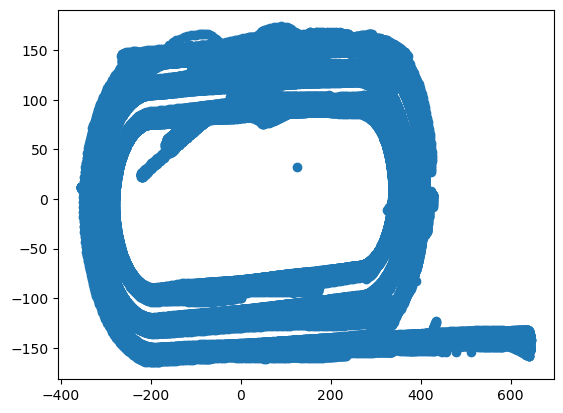

In [12]:
#plot to check rotation
print(tracking['track_id'].unique())
AQU = tracking[tracking['track_id'] == 'AQU']
plt.scatter(AQU['x_coord'],AQU['y_coord'])

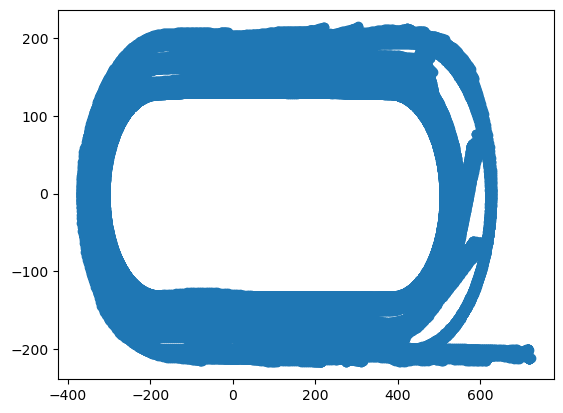

In [13]:
AQU = tracking[tracking['track_id'] == 'BEL']
plt.scatter(AQU['x_coord'],AQU['y_coord'])

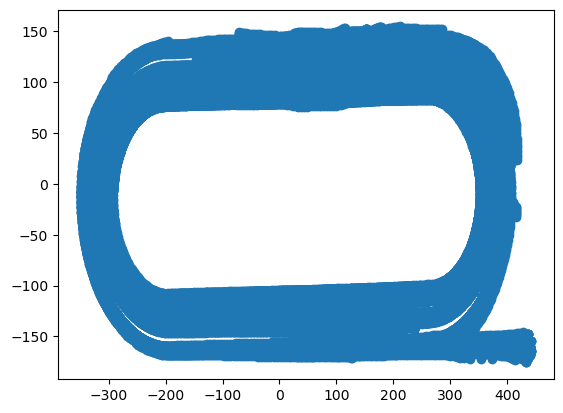

In [14]:
AQU = tracking[tracking['track_id'] == 'SAR']
plt.scatter(AQU['x_coord'],AQU['y_coord'])

In [15]:
# Add time to the dataframe
tracking['time'] = tracking['trakus_index'] * .25

### Group Start and Race Data

In [16]:
s_gs = start.groupby(['race_date','race_number'])
r_gs = race.groupby('race_date')

### Sort and Add Columns to Tracking Data

In [17]:
#tracking = tracking.sort_values(['race_date','race_number','program_number','trakus_index'])

tracking = tracking.sort_values(['race_date','race_number','trakus_index'])

#Last value for velocity will be meaningless for each racer
tracking['x_vel'] = (tracking['x_coord'] - tracking['x_coord'].shift(-1)) / .25
tracking['y_vel'] = (tracking['y_coord'] - tracking['y_coord'].shift(-1)) / .25
tracking['vel_mag'] = (tracking['x_vel']**2 + tracking['y_vel']**2)**(1/2)

#Last two values for acceleration will be meaningless for each racer
tracking['x_acc'] = (tracking['x_vel'] - tracking['x_vel'].shift(-1)) / .25
tracking['y_acc'] = (tracking['y_vel'] - tracking['y_vel'].shift(-1)) / .25
tracking['acc_mag'] = (tracking['x_acc']**2 + tracking['y_acc']**2)**(1/2)

In [18]:
tracking.head()

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,m_lat,m_lon,x_coord,y_coord,time,x_vel,y_vel,vel_mag,x_acc,y_acc,acc_mag
191041,AQU,2019-01-01,1,5,1,40.669386,-73.829145,-362.202404,38.583515,333.206873,-147.147709,0.25,-0.098503,-21.347370,21.347597,-15.496357,-116.156116,117.185240
867361,AQU,2019-01-01,1,1,1,40.669401,-73.829205,-360.599175,33.493117,333.231499,-141.810866,0.25,3.775586,7.691659,8.568353,23.591812,12.747254,26.815408
1133666,AQU,2019-01-01,1,2,1,40.669404,-73.829180,-360.286302,35.612233,332.287603,-143.733781,0.25,-2.122367,4.504845,4.979767,-68.466757,26.848003,73.542587
1212464,AQU,2019-01-01,1,3,1,40.669396,-73.829169,-361.134918,36.523128,332.818195,-144.859993,0.25,14.994322,-2.207155,15.155898,117.735925,-54.327615,129.665870
2014641,AQU,2019-01-01,1,4,1,40.669430,-73.829162,-357.396525,37.140173,329.069614,-144.308204,0.25,-14.439659,11.374749,18.381748,-57.362704,130.313813,142.380369


### Group Tracking Data

In [19]:
tracking = tracking.sort_values(by = ['race_date','track_id','race_number','trakus_index'])
tracking.head()

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,m_lat,m_lon,x_coord,y_coord,time,x_vel,y_vel,vel_mag,x_acc,y_acc,acc_mag
191041,AQU,2019-01-01,1,5,1,40.669386,-73.829145,-362.202404,38.583515,333.206873,-147.147709,0.25,-0.098503,-21.347370,21.347597,-15.496357,-116.156116,117.185240
867361,AQU,2019-01-01,1,1,1,40.669401,-73.829205,-360.599175,33.493117,333.231499,-141.810866,0.25,3.775586,7.691659,8.568353,23.591812,12.747254,26.815408
1133666,AQU,2019-01-01,1,2,1,40.669404,-73.829180,-360.286302,35.612233,332.287603,-143.733781,0.25,-2.122367,4.504845,4.979767,-68.466757,26.848003,73.542587
1212464,AQU,2019-01-01,1,3,1,40.669396,-73.829169,-361.134918,36.523128,332.818195,-144.859993,0.25,14.994322,-2.207155,15.155898,117.735925,-54.327615,129.665870
2014641,AQU,2019-01-01,1,4,1,40.669430,-73.829162,-357.396525,37.140173,329.069614,-144.308204,0.25,-14.439659,11.374749,18.381748,-57.362704,130.313813,142.380369


In [ ]:
def subgroup_distance(df, group_column='program_number'):    
    groups = df[group_column].unique()
    
    rows = df.shape[0]
    
    distances = np.zeros((rows,10))
    
    X = 'x_coord'
    Y = 'y_coord'
    vx = 'x_vel'
    vy = 'y_vel'
    
    count = 0
    nn = 0
    global num
    global tots
    global tms
    num += 1
    if num % 1000 == 0:
        ct = datetime.now()
        time = (ct-tms).total_seconds()
        tms = ct
        per = 1000 / time
        print(num)
        print(time)
        left = (tots-num) * per
        print(((tots-num) * per) / 3600)
    
    
    # finds total distance, residual from line on velocity, and projection of distance onto velocity line
    
    for g in range(len(groups)):
    
        t_delt = []
        
        group_points = df[df[group_column] == groups[g]][[X,Y,vx,vy]]
        
        non_group_points = df[df[group_column] != groups[g]][[X,Y,vx,vy]]
        
        v = np.array([group_points[vx],group_points[vy]]).T
        v /= np.linalg.norm(v)
        
        u = np.array([non_group_points[X] - group_points[X].item(),non_group_points[Y]-group_points[Y].item()])
        mag = np.linalg.norm(v)**2
        projs = v.dot(u)[0]/mag
        
        fps = np.argwhere(projs >= 0).T[0]
        bps = np.argwhere(projs < 0).T[0]
        
        dists = np.sqrt((np.array(non_group_points[X])-group_points[X].item())**2 + (np.array(non_group_points[Y])-group_points[Y].item())**2)
        
        diff = dists**2 - projs**2
        
        diff[diff<0] = 0
        
        rejs = np.sqrt(diff)
        
        frs = rejs[fps]
        brs = rejs[bps]
        
        if fps.size == 0:
            lst = [np.nan,np.nan,np.nan,np.nan,np.nan]
        else:
            index = fps[np.argmin(frs)]
            lst = [dists[index],rejs[index],projs[index],non_group_points.iloc[index][X].item(),non_group_points.iloc[index][Y].item()]
            
        if bps.size == 0:
            lst += [np.nan,np.nan,np.nan,np.nan,np.nan]
        else:
            index = bps[np.argmax(brs)]
            lst += [dists[index],rejs[index],projs[index],non_group_points.iloc[index][X].item(),non_group_points.iloc[index][Y].item()]
        
        distances[g] = lst
        
    df = pd.concat([df, pd.DataFrame(distances).set_index(df.index)], axis=1)
    df.columns = ['track_id','race_date','race_number','program_number','track_number','latitude','longitude','m_lat','m_lon','x_coord','y_coord','time','x_vel','y_vel','vel_mag','x_acc','y_acc','acc_mag','f_distance','f_rejection','f_projection','X_front','Y_front','b_distance','b_rejection','b_projection','X_behind','Y_behind']

    return df, count, nn

def calculate_distances(df):
    return subgroup_distance(df)

In [ ]:
tr = tracking.groupby(['race_date','race_number','trakus_index'])
num = 0
tots = tr.ngroups
tms = datetime.now()
print(tots)

In [ ]:
individuals = tracking.groupby(['race_date','race_number','program_number'])
times, count, nn = tracking.groupby(['race_date','race_number','trakus_index']).apply(calculate_distances).reset_index()

In [ ]:
times.head()

In [ ]:
print(count)
print(nn)

##### 
